<center>
    <h1><u>AML Infections Machine Learning Analysis</u></h1>
</center>

In [ ]:
#run once
#pip install openpyxl
#pip install lifelines

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, show, savefig, xlim, figure, \
                ylim, legend, boxplot, setp, axes
%matplotlib inline
import statsmodels.api as sm

admissions = pd.read_excel('data/aml_data_8.16.23.xlsx')
admissions.dropna(subset=['Cytarabine mg/m2/day'],inplace=True)
ads_cv = pd.get_dummies(admissions['CV_line'], drop_first = True)
cvs = ads_cv.columns
admissions = pd.concat([admissions, ads_cv], axis=1)
admissions['male'] = admissions['gender'].map({'M':1, 'F':0})

admissions.first_bmi_kg_m2 = admissions.first_bmi_kg_m2.replace(np.nan,admissions.first_bmi_kg_m2.median())
admissions.dropna(subset=['lowest_neutrophil'],inplace=True)
admissions.dropna(subset=['lowest_platelet'],inplace=True)
admissions.dropna(subset=['lowest_hemoglobin'],inplace=True)
admissions.dropna(subset=['lowest_monocytes'],inplace=True)
admissions.reset_index(inplace=True)
print('There are '+str(len(admissions))+' total admissions.')
neg_ads = admissions[admissions['infection_present'] == 0]
print('There are '+str(len(neg_ads))+' infection-negative admissions.')

There are 423 total admissions.
There are 338 infection-negative admissions.


# Baseline Fever and Baseline ANC models

In [2]:
# Baseline fever model
# (0, recall) is specificity/TNR. FPR = 1-0.38 = 0.62
# (1, recall) is sensitivity/TPR = 0.93
from sklearn.metrics import classification_report
fevers = admissions['max_temp_38.5']
infections = admissions['infection_present']
print(classification_report(infections,fevers))

              precision    recall  f1-score   support

           0       0.96      0.38      0.55       338
           1       0.27      0.93      0.42        85

    accuracy                           0.49       423
   macro avg       0.61      0.66      0.48       423
weighted avg       0.82      0.49      0.52       423



In [3]:
# Baseline ANC model
anc = admissions['neutropenia']
infections = admissions['infection_present']
print(classification_report(infections,anc))

              precision    recall  f1-score   support

           0       0.95      0.16      0.27       338
           1       0.22      0.96      0.36        85

    accuracy                           0.32       423
   macro avg       0.59      0.56      0.32       423
weighted avg       0.80      0.32      0.29       423



# Machine Learning Models

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn import model_selection

featureset = ['age','white_caucasian','first_bmi_kg_m2','lowest_neutrophil','lowest_platelet',
        'max_temp_38.5','Cytarabine mg/m2/day','levo','lowest_hemoglobin','lowest_monocytes',
        'Other', 'Port','male',
        'infection_present']
ads_CART = admissions[featureset]
X = ads_CART.drop(['infection_present'],axis=1)
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X))
y = ads_CART['infection_present']

#### Load results from 3/8/2024

In [ ]:
import pickle
with open('output/logreg_preds.pickle', 'rb') as handle:
    all_logreg_preds_2 = pickle.load(handle)
with open('output/knn_preds.pickle', 'rb') as handle:
    all_knn_preds = pickle.load(handle)
with open('output/rf_preds.pickle', 'rb') as handle:
    all_rf_preds = pickle.load(handle)
with open('output/y_tests.pickle', 'rb') as handle:
    all_y_tests = pickle.load(handle)
with open('output/scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)

## Logistic Regression

In [ ]:
# generating parameter grid
lr_params_2 = {'C':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1],'penalty':['l2'],'class_weight':[None],'solver':['liblinear']}
lr_grid_2 = model_selection.ParameterGrid(lr_params_2)

loo = LeaveOneOut()

all_logreg_preds_2 = []
all_y_tests = []

# iterate over grid and fit/score model with the varying hyperparameters
for param in lr_grid_2:
#     print(param)
    lr_clf = LogisticRegression(**param)  # unpacking param which is a dictionary
    logreg_preds = []
    y_tests = []
    
    for train_index, test_index in loo.split(X_normalized):
        X_train, X_test = X_normalized.loc[train_index], X_normalized.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_tests.append(y_test.iloc[0])
        
        lr_clf.fit(X_train, y_train)
        logreg_preds.append(lr_clf.predict_proba(X_test).T[1][0])
        
    all_logreg_preds_2.append(logreg_preds)
    all_y_tests.append(y_tests)

In [ ]:
# 4 {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
# AUC:  0.7476505395057432
# TPR close to Fever TPR 0.93:  0.9294117647058824
# FPR when TPR=0.93:  0.606508875739645
# TPR close to Fever FPR 0.62:  0.9411764705882353
# FPR when FPR=0.62:  0.6124260355029586

counter = -1
for param in lr_grid_2:
    counter += 1
    print(counter, param)

    fpr1, tpr1, thresh1 = roc_curve(all_y_tests[counter], all_logreg_preds_2[counter])
    auc1= roc_auc_score(all_y_tests[counter], all_logreg_preds_2[counter])
    
    print('AUC: ', auc1)
    print('TPR close to Fever TPR 0.93: ', tpr1[next(x[0] for x in enumerate(tpr1) if x[1] >= 0.929)])
    print('FPR when TPR=0.93: ',fpr1[next(x[0] for x in enumerate(tpr1) if x[1] >= 0.929)])

    rev_tpr1 = np.flip(tpr1)
    rev_fpr1 = np.flip(fpr1)
    print('TPR close to Fever FPR 0.62: ', rev_tpr1[next(x[0] for x in enumerate(rev_fpr1) if x[1] <= 0.62)]) 
    print('FPR when FPR=0.62: ', rev_fpr1[next(x[0] for x in enumerate(rev_fpr1) if x[1] <= 0.62)])    

    fig = plt.figure(figsize=(10, 6))
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : 14}
    plt.rc('font', **font)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(0.62,0.93,'o', label='Fever')
    plt.plot(0.84,0.96,'o', label='Neutropenia')
    plt.plot(fpr1, tpr1, label='Logistic regression (AUC = %0.3f)' % auc1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right');
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
lr_preds = all_logreg_preds_2[4]
lr_preds_mean = sum(all_logreg_preds_2[4])/len(all_logreg_preds_2[4])
plt = sns.histplot(data=lr_preds)
plt.axvline(lr_preds_mean, color='k', lw=2)
plt.axvline(np.median(np.array(lr_preds)), color='k', ls='--', lw=2)
plt.set_xlabel("BSI Predicted Probability")
fig = plt.get_figure()
# fig.savefig("output/pred_hist.png")

## Random Forest

In [ ]:
rf_params = {'n_estimators':[250],'max_depth':[1,2,5,8,10]}
rf_grid = model_selection.ParameterGrid(rf_params)
loo = LeaveOneOut()

all_rf_preds = []
all_y_rf_tests = []

for param in rf_grid:
    print(param)
    rf_clf = RandomForestClassifier(**param)
    rf_preds = []
    feat_imp = []
    y_tests = []
    for train_index, test_index in loo.split(X_normalized):
        X_train, X_test = X_normalized.loc[train_index], X_normalized.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_tests.append(y_test.iloc[0])
        
        rf_clf.fit(X_train, y_train)
        rf_preds.append(rf_clf.predict_proba(X_test).T[1][0])
        
    all_rf_preds.append(rf_preds)
    all_y_rf_tests.append(y_tests)

In [ ]:
# Best: 1 {'max_depth': 2, 'n_estimators': 250}
# AUC:  0.7388096066829098
# TPR close to Fever TPR 0.93:  0.9294117647058824
# FPR when TPR=0.93:  0.7071005917159763
# TPR close to Fever FPR 0.62:  0.8823529411764706
# FPR when FPR=0.62:  0.6035502958579881
counter = -1
for param in rf_grid:
    counter += 1
    print(counter, param)

    fpr3, tpr3, thresh3 = roc_curve(all_y_tests[counter], all_rf_preds[counter])
    auc3= roc_auc_score(all_y_tests[counter], all_rf_preds[counter])
    
    print('AUC: ', auc3)
    print('TPR close to Fever TPR 0.93: ', tpr3[next(x[0] for x in enumerate(tpr3) if x[1] >= 0.929)])
    print('FPR when TPR=0.93: ',fpr3[next(x[0] for x in enumerate(tpr3) if x[1] >= 0.929)])
    
    rev_tpr3 = np.flip(tpr3)
    rev_fpr3 = np.flip(fpr3)
    print('TPR close to Fever FPR 0.62: ', rev_tpr3[next(x[0] for x in enumerate(rev_fpr3) if x[1] <= 0.62)]) 
    print('FPR when FPR=0.62: ', rev_fpr3[next(x[0] for x in enumerate(rev_fpr3) if x[1] <= 0.62)])    
    
#     fig = plt.figure(figsize=(10, 6))
#     font = {'family' : 'normal',
#             'weight' : 'normal',
#             'size'   : 14}
#     plt.rc('font', **font)
#     plt.plot([0, 1], [0, 1], linestyle='--')
#     plt.plot(0.62,0.93,'o', label='Fever')
#     plt.plot(0.84,0.96,'o', label='Neutropenia')
#     plt.plot(fpr1, tpr1, label='Random Forest (AUC = %0.3f)' % auc3)
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.0])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend(loc='lower right');
#     plt.show()
    print()

## KNN

In [ ]:
knn_params = {'n_neighbors':[5,10,25,50,100],'weights':['uniform','distance']}
knn_grid = model_selection.ParameterGrid(knn_params)
loo = LeaveOneOut()

all_knn_preds = []
all_y_knn_tests = []

for param in knn_grid:
    print(param)
    knn_clf = KNeighborsClassifier(**param)
    knn_preds = []
    y_tests = []
    for train_index, test_index in loo.split(X_normalized):
        X_train, X_test = X_normalized.loc[train_index], X_normalized.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_tests.append(y_test.iloc[0])
        
        knn_clf.fit(X_train, y_train)
        knn_preds.append(knn_clf.predict_proba(X_test).T[1][0])
        
    all_knn_preds.append(knn_preds)
    all_y_knn_tests.append(y_tests)

In [ ]:
# Best: 6 {'n_neighbors': 50, 'weights': 'uniform'}
# AUC:  0.7123738252697528
# TPR close to Fever TPR 0.93:  0.9411764705882353
# FPR when TPR=0.93:  0.7366863905325444
# TPR close to Fever FPR 0.62:  0.8588235294117647
# FPR when FPR=0.62:  0.606508875739645
counter = -1
for param in knn_grid:
    counter += 1
    print(counter, param)

    fpr2, tpr2, thresh2 = roc_curve(all_y_tests[counter], all_knn_preds[counter])
    auc2= roc_auc_score(all_y_tests[counter], all_knn_preds[counter])
    
    print('AUC: ', auc2)
    print('TPR close to Fever TPR 0.93: ', tpr2[next(x[0] for x in enumerate(tpr2) if x[1] >= 0.929)])
    print('FPR when TPR=0.93: ',fpr2[next(x[0] for x in enumerate(tpr2) if x[1] >= 0.929)])
    
    rev_tpr2 = np.flip(tpr2)
    rev_fpr2 = np.flip(fpr2)
    print('TPR close to Fever FPR 0.62: ', rev_tpr2[next(x[0] for x in enumerate(rev_fpr2) if x[1] <= 0.62)]) 
    print('FPR when FPR=0.62: ', rev_fpr2[next(x[0] for x in enumerate(rev_fpr2) if x[1] <= 0.62)])    
    
#     fig = plt.figure(figsize=(10, 6))
#     font = {'family' : 'normal',
#             'weight' : 'normal',
#             'size'   : 14}
#     plt.rc('font', **font)
#     plt.plot([0, 1], [0, 1], linestyle='--')
#     plt.plot(0.62,0.93,'o', label='Fever')
#     plt.plot(0.84,0.96,'o', label='Neutropenia')
#     plt.plot(fpr1, tpr1, label='KNN (AUC = %0.3f)' % auc2)
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.0])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend(loc='lower right');
#     plt.show()
    print()

In [ ]:
# Saving our lists/findings
import pickle
with open('output/logreg_preds.pickle', 'wb') as handle:
    pickle.dump(all_logreg_preds_2, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('output/knn_preds.pickle', 'wb') as handle:
    pickle.dump(all_knn_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('output/rf_preds.pickle', 'wb') as handle:
    pickle.dump(all_rf_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('output/y_tests.pickle', 'wb') as handle:
    pickle.dump(all_y_tests, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('output/scaler.pickle', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Analyzing Results

In [5]:
import pickle
with open('output/logreg_preds.pickle', 'rb') as handle:
    all_logreg_preds_2 = pickle.load(handle)
with open('output/knn_preds.pickle', 'rb') as handle:
    all_knn_preds = pickle.load(handle)
with open('output/rf_preds.pickle', 'rb') as handle:
    all_rf_preds = pickle.load(handle)
with open('output/y_tests.pickle', 'rb') as handle:
    all_y_tests = pickle.load(handle)
with open('output/scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)

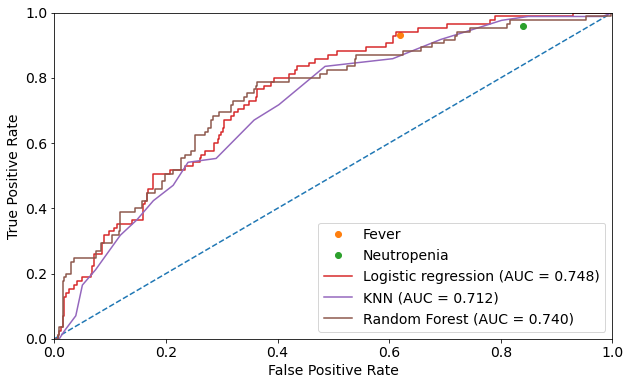

In [7]:
fpr1, tpr1, thresh1 = roc_curve(all_y_tests[4], all_logreg_preds_2[4])
auc1= roc_auc_score(all_y_tests[4], all_logreg_preds_2[4])

fpr2, tpr2, thresh2 = roc_curve(all_y_tests[6], all_knn_preds[6])
auc2= roc_auc_score(all_y_tests[6], all_knn_preds[6])

fpr3, tpr3, thresh3 = roc_curve(all_y_tests[1], all_rf_preds[1])
auc3= roc_auc_score(all_y_tests[1], all_rf_preds[1])

fig = plt.figure(figsize=(10, 6))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(0.62,0.93,'o', label='Fever')
plt.plot(0.84,0.96,'o', label='Neutropenia')
plt.plot(fpr1, tpr1, label='Logistic regression (AUC = %0.3f)' % auc1)
plt.plot(fpr2, tpr2, label='KNN (AUC = %0.3f)' % auc2)
plt.plot(fpr3, tpr3, label='Random Forest (AUC = %0.3f)' % auc3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right');
plt.show()
# fig.savefig('output/best_models_5.5.24.png',bbox_inches='tight')

### Zooming in on our best model -- regularized logistic regression

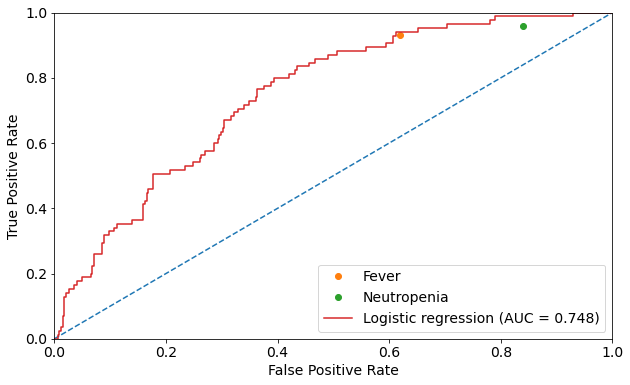

In [8]:
fpr1, tpr1, thresh1 = roc_curve(all_y_tests[4], all_logreg_preds_2[4])
auc1= roc_auc_score(all_y_tests[4], all_logreg_preds_2[4])

fig = plt.figure(figsize=(10, 6))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(0.62,0.93,'o', label='Fever')
plt.plot(0.84,0.96,'o', label='Neutropenia')
plt.plot(fpr1, tpr1, label='Logistic regression (AUC = %0.3f)' % auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right');
plt.show()
# fig.savefig('output/best_model_3.8.24.png',bbox_inches='tight')

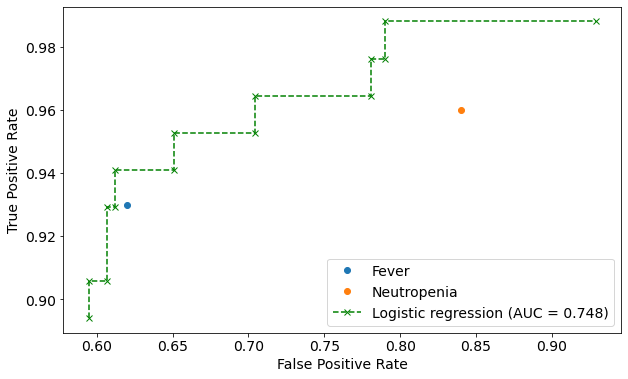

In [9]:
# 4 {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
fpr1, tpr1, thresh1 = roc_curve(all_y_tests[4], all_logreg_preds_2[4])
auc1= roc_auc_score(all_y_tests[4], all_logreg_preds_2[4])
fig = plt.figure(figsize=(10, 6))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.plot(0.62,0.93,'o', label='Fever')
plt.plot(0.84,0.96,'o', label='Neutropenia')
plt.plot(fpr1[110:125], tpr1[110:125], 'x--g', label='Logistic regression (AUC = %0.3f)' % auc1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right');
plt.show()
# fig.savefig('output/best_model_zoomedin_3.8.24.png',bbox_inches='tight')

In [10]:
print(tpr1[113],fpr1[113]) # same tpr, lower fpr
# print(tpr1[114],fpr1[114])
print(tpr1[115],fpr1[115]) # same/slightly lower fpr and higher tpr
print(tpr1[116],fpr1[116])

0.9294117647058824 0.606508875739645
0.9411764705882353 0.6124260355029586
0.9411764705882353 0.650887573964497


### Finding the most important features in the best random forest model

In [11]:
rf = RandomForestClassifier(max_depth=2, n_estimators=250)
rf.fit(X_normalized,y)
rf.feature_importances_

array([0.06623489, 0.00453827, 0.06170174, 0.15339292, 0.07936694,
       0.20749406, 0.23318204, 0.03370463, 0.03318358, 0.11006361,
       0.00785769, 0.00666976, 0.00260986])

In [ ]:
featureset = ['age','white_caucasian','first_bmi_kg_m2','lowest_neutrophil','lowest_platelet',
        'max_temp_38.5','Cytarabine mg/m2/day','levo','lowest_hemoglobin','lowest_monocytes',
        'Other', 'Port','male',
        'infection_present']
# max_temp_28.5, lowest_neutrophil, Cytarabine mg/m2/day, lowest_monocytes, first_bmi_kg_m2
# lowest_platelet

### Comparing our best model to fever model using confusion matrices

In [12]:
from sklearn.metrics import classification_report
fevers = admissions['max_temp_38.5']
infections = admissions['infection_present']
print(classification_report(infections,fevers))

              precision    recall  f1-score   support

           0       0.96      0.38      0.55       338
           1       0.27      0.93      0.42        85

    accuracy                           0.49       423
   macro avg       0.61      0.66      0.48       423
weighted avg       0.82      0.49      0.52       423



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


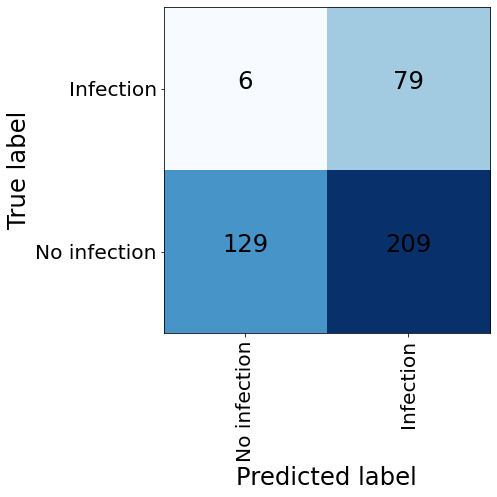

In [13]:
from sklearn.metrics import confusion_matrix
cMatrix = confusion_matrix(y_true = infections, y_pred = fevers)
fig = plt.figure(figsize=(10, 6))
plt.imshow(cMatrix, cmap=plt.cm.Blues)
plt.text(0, 0, '{}'.format(cMatrix[0, 0]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(0, 1, '{}'.format(cMatrix[1, 0]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(1, 0, '{}'.format(cMatrix[0, 1]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(1, 1, '{}'.format(cMatrix[1, 1]), horizontalalignment='center',fontsize = 'xx-large')
tick_marks = [0,1]
labels = ['No infection', 'Infection']
plt.xticks(tick_marks, labels, rotation=90,fontsize = 'x-large')
plt.ylim([-0.5,1.5])
plt.yticks(tick_marks, labels,fontsize = 'x-large')
plt.ylabel('True label',fontsize = 'xx-large')
plt.xlabel('Predicted label',fontsize = 'xx-large')
plt.show()

In [14]:
fpr1, tpr1, thresh1 = roc_curve(all_y_tests[4], all_logreg_preds_2[4])
auc1= roc_auc_score(all_y_tests[4], all_logreg_preds_2[4])
lr_preds_class = all_logreg_preds_2[4]
lrrounds = []
for i in lr_preds_class:
    if i > thresh1[next(x[0] for x in enumerate(tpr1) if x[1] > 0.93)]:
        lrrounds.append(1)
    else:
        lrrounds.append(0)
print(thresh1[next(x[0] for x in enumerate(tpr1) if x[1] > 0.93)])

0.31183791167153174


In [15]:
from sklearn.metrics import classification_report
lr_preds_f = pd.cut(lr_preds_class,bins=[-1,0.31183791167153174,1],right=True,labels=[0,1])
print(classification_report(all_y_tests[7],lr_preds_f))

              precision    recall  f1-score   support

           0       0.96      0.39      0.55       338
           1       0.28      0.93      0.43        85

    accuracy                           0.50       423
   macro avg       0.62      0.66      0.49       423
weighted avg       0.82      0.50      0.53       423



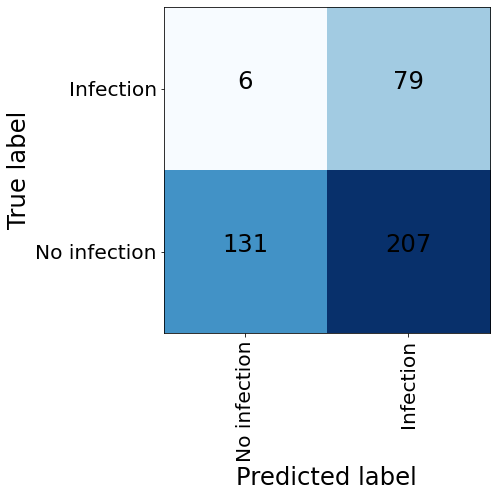

In [16]:
from sklearn.metrics import confusion_matrix
cMatrix = confusion_matrix(y_true = all_y_tests[4], y_pred = lr_preds_f)
fig = plt.figure(figsize=(10, 6))
plt.imshow(cMatrix, cmap=plt.cm.Blues)
plt.text(0, 0, '{}'.format(cMatrix[0, 0]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(0, 1, '{}'.format(cMatrix[1, 0]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(1, 0, '{}'.format(cMatrix[0, 1]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(1, 1, '{}'.format(cMatrix[1, 1]), horizontalalignment='center',fontsize = 'xx-large')
tick_marks = [0,1]
labels = ['No infection', 'Infection']
plt.xticks(tick_marks, labels, rotation=90,fontsize = 'x-large')
plt.ylim([-0.5,1.5])
plt.yticks(tick_marks, labels,fontsize = 'x-large')
plt.ylabel('True label',fontsize = 'xx-large')
plt.xlabel('Predicted label',fontsize = 'xx-large')
plt.show()

## Real-world application

In [17]:
import pickle
with open('output/logreg_preds.pickle', 'rb') as handle:
    all_logreg_preds_2 = pickle.load(handle)
with open('output/knn_preds.pickle', 'rb') as handle:
    all_knn_preds = pickle.load(handle)
with open('output/rf_preds.pickle', 'rb') as handle:
    all_rf_preds = pickle.load(handle)
with open('output/y_tests.pickle', 'rb') as handle:
    all_y_tests = pickle.load(handle)
with open('output/scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)

#### Find threshold for desired TPR

In [18]:
fpr1, tpr1, thresh1 = roc_curve(all_y_tests[4], all_logreg_preds_2[4])
auc1= roc_auc_score(all_y_tests[4], all_logreg_preds_2[4])
lr_preds_class = all_logreg_preds_2[4]
lrrounds = []
for i in lr_preds_class:
    if i > thresh1[next(x[0] for x in enumerate(tpr1) if x[1] > 0.955)]:
        lrrounds.append(1)
    else:
        lrrounds.append(0)
print(thresh1[next(x[0] for x in enumerate(tpr1) if x[1] > 0.955)])

0.29014161446620707


In [19]:
from sklearn.metrics import classification_report
lr_preds_f = pd.cut(lr_preds_class,bins=[-1,0.29014161446620707,1],right=True,labels=[0,1])
print(classification_report(all_y_tests[4],lr_preds_f))

              precision    recall  f1-score   support

           0       0.96      0.30      0.45       338
           1       0.25      0.95      0.40        85

    accuracy                           0.43       423
   macro avg       0.61      0.62      0.43       423
weighted avg       0.82      0.43      0.44       423



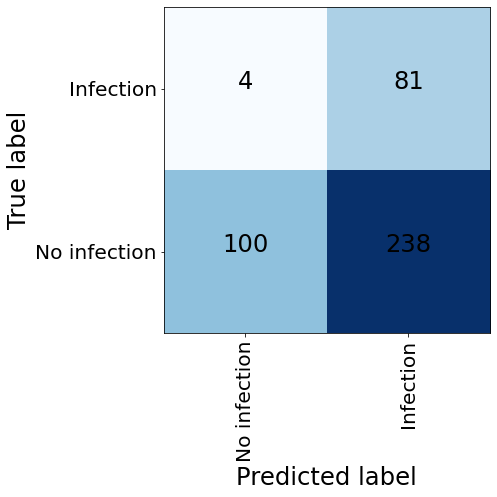

In [20]:
from sklearn.metrics import confusion_matrix
cMatrix = confusion_matrix(y_true = all_y_tests[4], y_pred = lr_preds_f)
fig = plt.figure(figsize=(10, 6))
plt.imshow(cMatrix, cmap=plt.cm.Blues)
plt.text(0, 0, '{}'.format(cMatrix[0, 0]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(0, 1, '{}'.format(cMatrix[1, 0]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(1, 0, '{}'.format(cMatrix[0, 1]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(1, 1, '{}'.format(cMatrix[1, 1]), horizontalalignment='center',fontsize = 'xx-large')
tick_marks = [0,1]
labels = ['No infection', 'Infection']
plt.xticks(tick_marks, labels, rotation=90,fontsize = 'x-large')
plt.ylim([-0.5,1.5])
plt.yticks(tick_marks, labels,fontsize = 'x-large')
plt.ylabel('True label',fontsize = 'xx-large')
plt.xlabel('Predicted label',fontsize = 'xx-large')
plt.show()

### Predict BSI for new admissions

Best model LR {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
<br> Threshold: 0.30609164636288244

In [21]:
new_patient = pd.read_excel('data/New Patient Data Blinded.xlsx')
new_patient['male'] = new_patient['gender'].map({'M':1, 'F':0})
new_patient['Port'] = 0
new_patient['Other'] = 0
features = ['age',
        'white_caucasian','first_bmi_kg_m2','lowest_neutrophil','lowest_platelet',
        'max_temp_38.5','Cytarabine mg/m2/day','levo',
        'lowest_hemoglobin','lowest_monocytes',
        'Other', 'Port',
        'male']
new_patient = new_patient[features]
new_patient_normalized = scaler.transform(new_patient)

best_model = LogisticRegression(C=0.01, class_weight=None, penalty='l2', solver='liblinear')
best_model.fit(X_normalized,y)
best_model.predict_proba(new_patient_normalized).T[1]

array([0.26885912])

In [22]:
best_model.coef_

array([[ 0.05413702,  0.06228247,  0.02771054, -0.04637815, -0.0888361 ,
         0.21912577,  0.12689446, -0.12786271,  0.08458082, -0.07113245,
         0.05315441,  0.03610469,  0.04559439]])

In [23]:
new_patient = pd.read_excel('data/New Patient No Fever BSI Pos.xlsx')
new_patient['male'] = new_patient['gender'].map({'M':1, 'F':0})
new_patient['Port'] = 1
new_patient['Other'] = 0
features = ['age',
        'white_caucasian','first_bmi_kg_m2','lowest_neutrophil','lowest_platelet',
        'max_temp_38.5','Cytarabine mg/m2/day','levo',
        'lowest_hemoglobin','lowest_monocytes',
        'Other', 'Port',
        'male']
new_patient = new_patient[features]
new_patient_normalized = scaler.transform(new_patient)
best_model = LogisticRegression(C=0.01, class_weight=None, penalty='l2', solver='liblinear')
best_model.fit(X_normalized,y)
best_model.predict_proba(new_patient_normalized).T[1]

array([0.36729824])

# Logistic Regression Univariate Analysis for Explanation

In [24]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, show, savefig, xlim, figure, \
                ylim, legend, boxplot, setp, axes
%matplotlib inline
import statsmodels.api as sm

admissions = pd.read_excel('data/aml_data_8.16.23.xlsx')
admissions.dropna(subset=['cytarabine'],inplace=True)
ads_cv = pd.get_dummies(admissions['CV_line'], drop_first = True)
cvs = ads_cv.columns
admissions = pd.concat([admissions, ads_cv], axis=1)
admissions['male'] = admissions['gender'].map({'M':1, 'F':0})

print('There are '+str(len(admissions))+' total admissions.')
neg_ads = admissions[admissions['infection_present'] == 0]
print('There are '+str(len(neg_ads))+' infection-negative admissions.')

There are 429 total admissions.
There are 343 infection-negative admissions.


#### Cytarabine

In [25]:
# continuous cytarabine
admissions['Cytarabine_g/m2/day'] = admissions['Cytarabine mg/m2/day']*0.001
featureset = ['age','male','white_caucasian','Cytarabine_g/m2/day','infection_present']
ads_logreg = admissions[featureset]
target = ads_logreg['infection_present']
features = ads_logreg.drop(['infection_present'],axis=1)
model = sm.Logit(target, sm.add_constant(features))
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.483703
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      infection_present   No. Observations:                  429
Model:                          Logit   Df Residuals:                      424
Method:                           MLE   Df Model:                            4
Date:                Wed, 08 May 2024   Pseudo R-squ.:                 0.03462
Time:                        10:16:36   Log-Likelihood:                -207.51
converged:                       True   LL-Null:                       -214.95
Covariance Type:            nonrobust   LLR p-value:                  0.004952
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.2413      0.312     -7.181      0.000      -2.853      -1.630
age                     0.0313      0.023      1.366      0.172      -0.014       0.076
male                    0.2831      0.263      1.077      0.281      -0.232       0.798
white_caucasian         0.3430      0.281      1.220      0.223      -0.208       0.894
Cytarabine_g/m2/day     0.1166      0.047      2.494      0.013       0.025       0.208
=======================================================================================
"""

#### Levofloxacin

In [26]:
featureset = ['age','male','white_caucasian','levo','infection_present']
ads_logreg = admissions[featureset]
target = ads_logreg['infection_present']
features = ads_logreg.drop(['infection_present'],axis=1)
model = sm.Logit(target, sm.add_constant(features))
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.481614
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      infection_present   No. Observations:                  429
Model:                          Logit   Df Residuals:                      424
Method:                           MLE   Df Model:                            4
Date:                Wed, 08 May 2024   Pseudo R-squ.:                 0.03879
Time:                        10:16:37   Log-Likelihood:                -206.61
converged:                       True   LL-Null:                       -214.95
Covariance Type:            nonrobust   LLR p-value:                  0.002236
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.8782      0.320     -5.871      0.000      -2.505      -1.251
age                 0.0363      0.023      1.586      0.113      -0.009       0.081
male                0.1998      0.266      0.752      0.452      -0.321       0.720
white_caucasian     0.4431      0.282      1.571      0.116      -0.110       0.996
levo               -0.7517      0.280     -2.689      0.007      -1.300      -0.204
===================================================================================
"""

#### All Treatments and Controls (age,sex,race)

In [27]:
admissions = pd.read_excel('data/aml_data_8.16.23.xlsx')
admissions.dropna(subset=['Cytarabine mg/m2/day'],inplace=True)
admissions['male'] = admissions['gender'].map({'M':1, 'F':0})
admissions['Cytarabine_g/m2/day'] = admissions['Cytarabine mg/m2/day']*0.001
featureset = ['age','male','white_caucasian','Cytarabine_g/m2/day','levo','infection_present']
ads_logreg = admissions[featureset]
target = ads_logreg['infection_present']
features = ads_logreg.drop(['infection_present'],axis=1)
model = sm.Logit(target, sm.add_constant(features))
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.475943
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      infection_present   No. Observations:                  429
Model:                          Logit   Df Residuals:                      423
Method:                           MLE   Df Model:                            5
Date:                Wed, 08 May 2024   Pseudo R-squ.:                 0.05011
Time:                        10:16:38   Log-Likelihood:                -204.18
converged:                       True   LL-Null:                       -214.95
Covariance Type:            nonrobust   LLR p-value:                 0.0006401
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.9770      0.325     -6.090      0.000      -2.613      -1.341
age                     0.0301      0.023      1.292      0.197      -0.016       0.076
male                    0.1933      0.268      0.720      0.471      -0.333       0.719
white_caucasian         0.4051      0.284      1.425      0.154      -0.152       0.962
Cytarabine_g/m2/day     0.1044      0.047      2.238      0.025       0.013       0.196
levo                   -0.7039      0.281     -2.501      0.012      -1.256      -0.152
=======================================================================================
"""

#### Cumulative cytarabine dose per cycle

In [28]:
admissions['Cytarabine_g/m2/day_cumulative'] = admissions['Cytarabine mg/m2']*0.001
featureset = ['age','male','white_caucasian','Cytarabine_g/m2/day_cumulative','infection_present']
ads_logreg = admissions[featureset]
target = ads_logreg['infection_present']
features = ads_logreg.drop(['infection_present'],axis=1)
model = sm.Logit(target, sm.add_constant(features))
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.479163
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      infection_present   No. Observations:                  429
Model:                          Logit   Df Residuals:                      424
Method:                           MLE   Df Model:                            4
Date:                Wed, 08 May 2024   Pseudo R-squ.:                 0.04368
Time:                        10:16:38   Log-Likelihood:                -205.56
converged:                       True   LL-Null:                       -214.95
Covariance Type:            nonrobust   LLR p-value:                 0.0008693
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -2.5234      0.340     -7.413      0.000      -3.191      -1.856
age                                0.0324      0.023      1.408      0.159      -0.013       0.077
male                               0.2676      0.264      1.013      0.311      -0.250       0.785
white_caucasian                    0.3516      0.283      1.243      0.214      -0.203       0.906
Cytarabine_g/m2/day_cumulative     0.0847      0.027      3.144      0.002       0.032       0.138
==================================================================================================
"""

# Survival Analysis: Kaplan Meier Curve

Text(0, 0.5, 'Probability of Survival')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


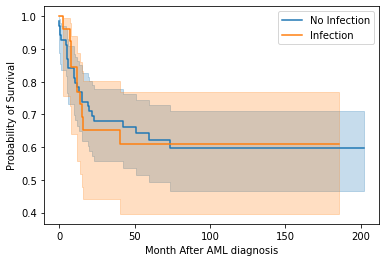

In [29]:
from lifelines import KaplanMeierFitter
admissions = pd.read_excel('data/aml_data_8.16.23.xlsx')
# infected vs not infected
kmf = KaplanMeierFitter()
kmc_ads = admissions.drop_duplicates(subset='MRN',keep='last')
X = kmc_ads['survival_months']
Y = kmc_ads['deceased']
score_group = kmc_ads['infection_present'] == 1
ax = plt.subplot(111)
kmf.fit(X[~score_group], event_observed = Y[~score_group], label = 'No Infection')
kmf.plot(ax = ax)
kmf.fit(X[score_group], event_observed = Y[score_group], label = 'Infection')
kmf.plot(ax = ax)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
#plt.title("Kaplan Meier Estimates by Infection/No Infection")
plt.xlabel("Month After AML diagnosis")
plt.ylabel("Probability of Survival")
# plt.savefig('output/KM_infections.png',bbox_inches='tight')

In [30]:
print(len(Y)) # num patients
print(sum(Y)) # num deaths
print(sum(Y)/len(Y)) # death ratio

95
36
0.37894736842105264


In [31]:
# logrank test
from lifelines.statistics import logrank_test
results=logrank_test(X[~score_group],X[score_group],event_observed_A=Y[~score_group], event_observed_B=Y[score_group])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.97      0.04

Text(0, 0.5, 'Probability of Survival')

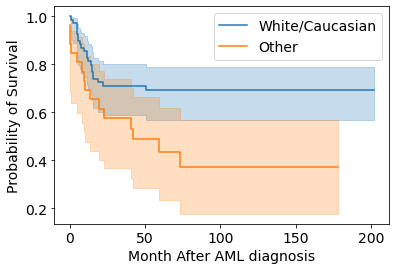

In [32]:
# race (white vs. other)
kmf = KaplanMeierFitter()
kmc_ads = admissions.drop_duplicates(subset='MRN',keep='last')
X = kmc_ads['survival_months']
Y = kmc_ads['deceased']
score_group = kmc_ads['white_caucasian'] == 1
ax = plt.subplot(111)
kmf.fit(X[score_group], event_observed = Y[score_group], label = 'White/Caucasian')
kmf.plot(ax = ax)
kmf.fit(X[~score_group], event_observed = Y[~score_group], label = 'Other')
kmf.plot(ax = ax)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
#plt.title("Kaplan Meier Estimates by Race")
plt.xlabel("Month After AML diagnosis")
plt.ylabel("Probability of Survival")
# plt.savefig('output/KM_race.png',bbox_inches='tight')

In [33]:
results=logrank_test(X[score_group],X[~score_group],event_observed_A=Y[score_group], event_observed_B=Y[~score_group])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.00 0.01      6.13

#### Survival grouped by patients diagnosed 2005-2009, vs 2010-2014, vs 2015 – 2019 to view survival difference

In [34]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, show, savefig, xlim, figure, \
                ylim, legend, boxplot, setp, axes
%matplotlib inline
import statsmodels.api as sm

admissions = pd.read_excel('data/aml_data_8.16.23.xlsx')

print('There are '+str(len(admissions))+' total admissions.')
neg_ads = admissions[admissions['infection_present'] == 0]
print('There are '+str(len(neg_ads))+' infection-negative admissions.')

There are 480 total admissions.
There are 389 infection-negative admissions.


In [35]:
kmc_ads = admissions.drop_duplicates(subset='MRN',keep='first')
kmc_5_9_ads = kmc_ads[(kmc_ads['admit_date'] >= '2005') & (kmc_ads['admit_date'] < '2010')]
print('Death rate 2005-2009:',len(kmc_5_9_ads[kmc_5_9_ads['deceased'] == 1])/len(kmc_5_9_ads))
print('Survival rate 2005-2009:',len(kmc_5_9_ads[kmc_5_9_ads['deceased'] == 0])/len(kmc_5_9_ads))
print('Number survived:',len(kmc_5_9_ads[kmc_5_9_ads['deceased'] == 0]))
len(kmc_5_9_ads)

Death rate 2005-2009: 0.3888888888888889
Survival rate 2005-2009: 0.6111111111111112
Number survived: 22


36

In [36]:
kmc_10_14_ads = kmc_ads[(kmc_ads['admit_date'] >= '2010') & (kmc_ads['admit_date'] < '2015')]
print('Death rate 2010-2014:',len(kmc_10_14_ads[kmc_10_14_ads['deceased'] == 1])/len(kmc_10_14_ads))
print('Survival rate 2010-2014:',len(kmc_10_14_ads[kmc_10_14_ads['deceased'] == 0])/len(kmc_10_14_ads))
print('Number survived:',len(kmc_10_14_ads[kmc_10_14_ads['deceased'] == 0]))
len(kmc_10_14_ads)

Death rate 2010-2014: 0.35714285714285715
Survival rate 2010-2014: 0.6428571428571429
Number survived: 18


28

In [37]:
kmc_15_19_ads = kmc_ads[(kmc_ads['admit_date'] >= '2015') & (kmc_ads['admit_date'] < '2020')]
print('Death rate 2015-2019:',len(kmc_15_19_ads[kmc_15_19_ads['deceased'] == 1])/len(kmc_15_19_ads))
print('Survival rate 2015-2019:',len(kmc_15_19_ads[kmc_15_19_ads['deceased'] == 0])/len(kmc_15_19_ads))
print('Number survived:',len(kmc_15_19_ads[kmc_15_19_ads['deceased'] == 0]))
len(kmc_15_19_ads)

Death rate 2015-2019: 0.3870967741935484
Survival rate 2015-2019: 0.6129032258064516
Number survived: 19


31